In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score

In [2]:
#Retrieve the Tennis csv file

"""Tennis service stats for each player given in a 52-week period. 
Data collected Sat. 04/13/2019 from www.atptour.com"""
tennis = pd.read_csv('tennis_serve_stats_adjusted2.csv',encoding='latin-1')

In [3]:
#Several null values in the Height feature.
tennis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 0 to 161
Data columns (total 10 columns):
Player                     162 non-null object
1stServe%                  162 non-null float64
1st_Serve%_Points_Won      162 non-null float64
2nd_Serve%_Points_Won      162 non-null float64
Service%_Games_Won         162 non-null float64
Avg_Aces/Match             162 non-null float64
Avg_Double_Faults/Match    162 non-null float64
Age                        162 non-null float64
Height                     157 non-null float64
Gender                     162 non-null object
dtypes: float64(8), object(2)
memory usage: 12.7+ KB


In [4]:
tennis.iloc[:82,0].head()

0       John Isner
1     Ivo Karlovic
2     Milos Raonic
3    Roger Federer
4     Nick Kyrgios
Name: Player, dtype: object

In [5]:
# Set the player as the index
tennis.index = tennis.Player
tennis = tennis.drop(['Player'], axis = 1)

In [6]:
for i in tennis.columns[0:5]:
    tennis[i] = tennis[i].astype(str)
    tennis[i] = tennis[i].str.rstrip('%')
    tennis[i] = tennis[i].astype('float64')


cols = list(tennis)
cols.insert(0, cols.pop(cols.index('Avg_Aces/Match')))

tennis = tennis.ix[:,cols]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


In [7]:
# Fill in missing heights with the avgerage with heights.
tennis = tennis.fillna(tennis.mean())

In [8]:
#Set the gender to dummy variables.
tennis.Gender = pd.get_dummies(tennis.Gender, drop_first=True)

In [9]:
#A naive Model just to examine some trend before modeling
tennis_naive_lr = LinearRegression()
Avg_Aces = tennis.iloc[:, 0]
other_serve_stats = tennis.iloc[:, 1:]
tennis_naive_model_lr = sm.OLS(Avg_Aces, other_serve_stats)
fit = tennis_naive_model_lr.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Avg_Aces/Match   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     125.1
Date:                Tue, 25 Jun 2019   Prob (F-statistic):           2.25e-63
Time:                        19:04:31   Log-Likelihood:                -369.42
No. Observations:                 162   AIC:                             754.8
Df Residuals:                     154   BIC:                             779.5
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
1stServe%                  -0.1047      0.053     -1.966      0.051      -0.210       0.000
1st_Serve%_Points_Won       0.1200      0.113      1.065      0.288      -0.103       0.343
2nd_Serve%_Points_Won      -0.5079      0.086     -5.887      0.000      -0.678      -0.337
Service%_Games_Won          0.3719      0.082      4.536      0.000       0.210       0.534
Avg_Double_Faults/Match     0.0581      0.202      0.288      0.774      -0.340       0.456
Age                        -0.0037      0.043     -0.086      0.932      -0.089       0.082
Height                      0.0014      0.035      0.039      0.969      -0.067       0.070
Gender                      0.7538      0.608      1.241      0.217      -0.447       1.954
==============================================================================
Omnibus:                      121.259   Durbin-Watson:                   0.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1088.778
Skew:                           2.736   Prob(JB):                    3.76e-237
Kurtosis:                      14.461   Cond. No.                         721.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
#Naive model on men alone
Avg_Men_Aces = tennis.iloc[:82, 0]
other_serve_stats = tennis.iloc[:82, 1:]
tennis_naive_model_lr = sm.OLS(Avg_Men_Aces, other_serve_stats)
fit = tennis_naive_model_lr.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Avg_Aces/Match   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     50.08
Date:                Tue, 25 Jun 2019   Prob (F-statistic):           1.50e-25
Time:                        19:04:31   Log-Likelihood:                -161.35
No. Observations:                  82   AIC:                             338.7
Df Residuals:                      74   BIC:                             357.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
1stServe%                   0.3475      0.087      4.012      0.000       0.175       0.520
1st_Serve%_Points_Won       0.8729      0.196      4.461      0.000       0.483       1.263
2nd_Serve%_Points_Won      -0.0807      0.169     -0.479      0.633      -0.417       0.255
Service%_Games_Won         -0.1072      0.190     -0.564      0.575      -0.486       0.272
Avg_Double_Faults/Match     0.5585      0.271      2.057      0.043       0.018       1.099
Age                         0.0434      0.045      0.969      0.336      -0.046       0.133
Height                      0.1207      0.040      3.023      0.003       0.041       0.200
Gender                    -90.6017     10.360     -8.746      0.000    -111.244     -69.960
==============================================================================
Omnibus:                        3.739   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.154   Jarque-Bera (JB):                2.990
Skew:                           0.368   Prob(JB):                        0.224
Kurtosis:                       3.578   Cond. No.                     1.20e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.2e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [11]:
tennis.describe()

,Avg_Aces/Match,1stServe%,1st_Serve%_Points_Won,2nd_Serve%_Points_Won,Service%_Games_Won,Avg_Double_Faults/Match,Age,Height,Gender
count,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.00000,162.000000
mean,5.349383,61.201852,69.018519,48.693827,73.986420,3.311111,26.660494,182.33758,0.506173
std,3.669909,4.059503,5.341868,4.114837,8.689849,1.208099,4.735440,8.71748,0.501512
min,1.400000,50.300000,57.200000,39.800000,53.100000,1.100000,17.000000,163.00000,0.000000
25%,2.900000,58.425000,65.125000,45.825000,67.075000,2.400000,23.000000,175.00000,0.000000
50%,4.300000,61.150000,68.950000,48.900000,75.100000,3.150000,27.000000,182.33758,1.000000
75%,6.875000,64.200000,72.475000,51.600000,80.400000,4.000000,30.000000,188.00000,1.000000
max,23.100000,71.000000,83.800000,60.700000,94.100000,7.200000,40.000000,211.00000,1.000000


In [12]:
tennis.corr()

,Avg_Aces/Match,1stServe%,1st_Serve%_Points_Won,2nd_Serve%_Points_Won,Service%_Games_Won,Avg_Double_Faults/Match,Age,Height,Gender
Avg_Aces/Match,1.000000,0.027231,0.822126,0.409982,0.688376,0.090880,0.210945,0.736444,0.504691
1stServe%,0.027231,1.000000,-0.100745,0.294080,0.213727,-0.415017,0.045655,0.027286,0.103265
1st_Serve%_Points_Won,0.822126,-0.100745,1.000000,0.604420,0.895231,-0.031774,0.247041,0.751486,0.710565
2nd_Serve%_Points_Won,0.409982,0.294080,0.604420,1.000000,0.836942,-0.460483,0.176739,0.454975,0.691373
Service%_Games_Won,0.688376,0.213727,0.895231,0.836942,1.000000,-0.271088,0.229194,0.685452,0.768638
Avg_Double_Faults/Match,0.090880,-0.415017,-0.031774,-0.460483,-0.271088,1.000000,-0.183798,0.054460,-0.196944
Age,0.210945,0.045655,0.247041,0.176739,0.229194,-0.183798,1.000000,0.196618,0.274194
Height,0.736444,0.027286,0.751486,0.454975,0.685452,0.054460,0.196618,1.000000,0.678125
Gender,0.504691,0.103265,0.710565,0.691373,0.768638,-0.196944,0.274194,0.678125,1.000000


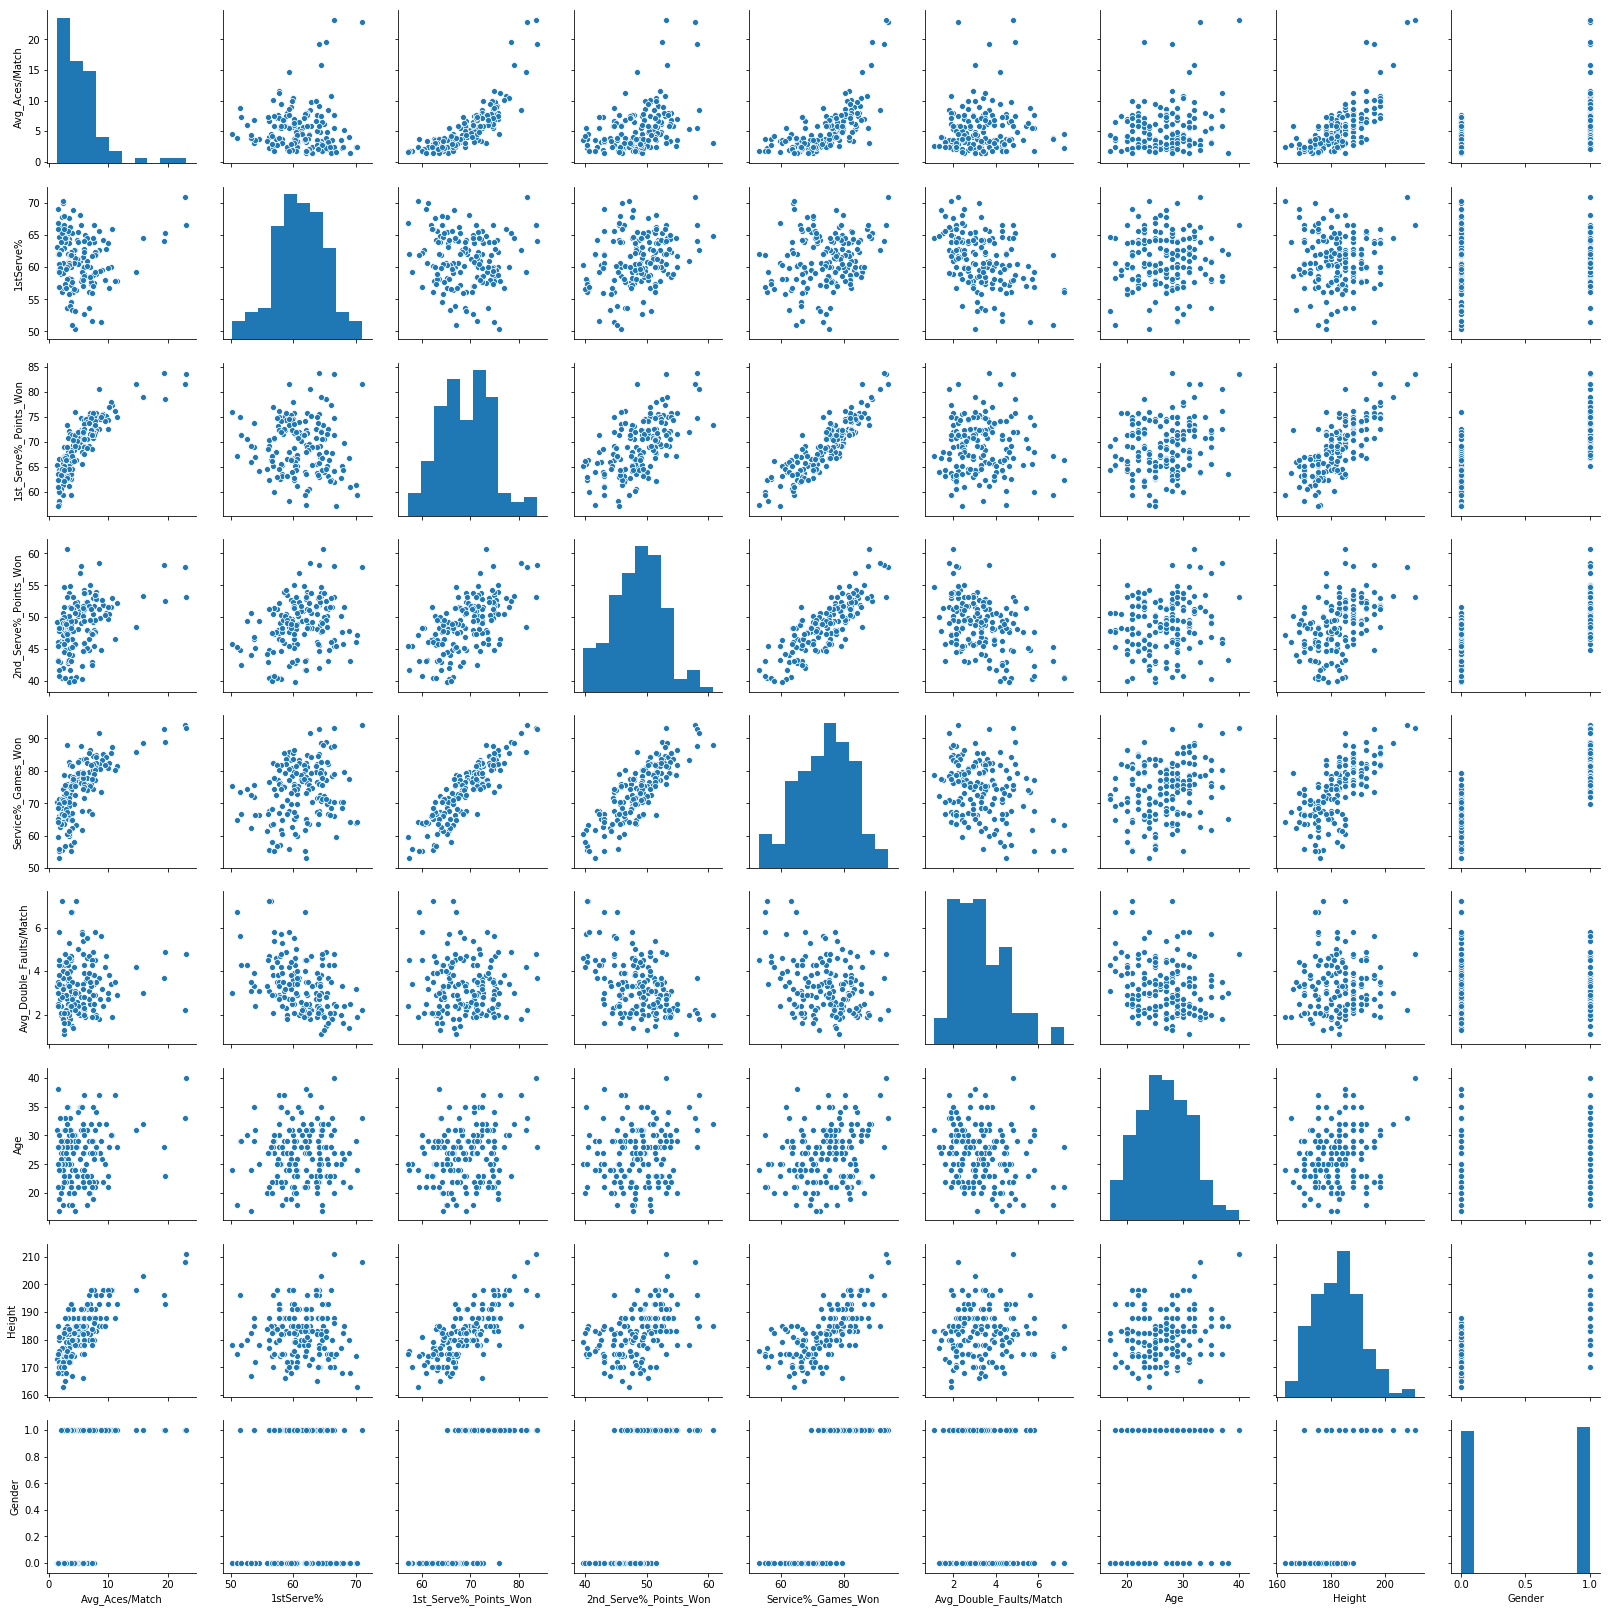

In [13]:
sns.pairplot(tennis);

In [14]:
#More cleaning/ time to cut feature that skew the data or obviously need to be dropped.
tennis = tennis.drop('Service%_Games_Won', axis=1)

In [15]:
#Rerun the naive model after removing the variables which exibited colinearality.
tennis_naive_lr = LinearRegression()
Avg_Aces = tennis.iloc[:, 0]
other_serve_stats = tennis.iloc[:, 1:]
tennis_naive_model_lr = sm.OLS(Avg_Aces, other_serve_stats)
fit = tennis_naive_model_lr.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Avg_Aces/Match   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     124.3
Date:                Tue, 25 Jun 2019   Prob (F-statistic):           2.85e-60
Time:                        19:04:40   Log-Likelihood:                -379.57
No. Observations:                 162   AIC:                             773.1
Df Residuals:                     155   BIC:                             794.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
1stServe%                  -0.0371      0.054     -0.684      0.495      -0.144       0.070
1st_Serve%_Points_Won       0.5293      0.072      7.393      0.000       0.388       0.671
2nd_Serve%_Points_Won      -0.3207      0.080     -3.989      0.000      -0.480      -0.162
Avg_Double_Faults/Match    -0.1321      0.209     -0.631      0.529      -0.545       0.281
Age                        -0.0413      0.045     -0.918      0.360      -0.130       0.048
Height                     -0.0706      0.033     -2.171      0.031      -0.135      -0.006
Gender                      2.3122      0.532      4.347      0.000       1.262       3.363
==============================================================================
Omnibus:                      128.362   Durbin-Watson:                   0.831
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1365.744
Skew:                           2.878   Prob(JB):                    2.71e-297
Kurtosis:                      16.008   Cond. No.                         561.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

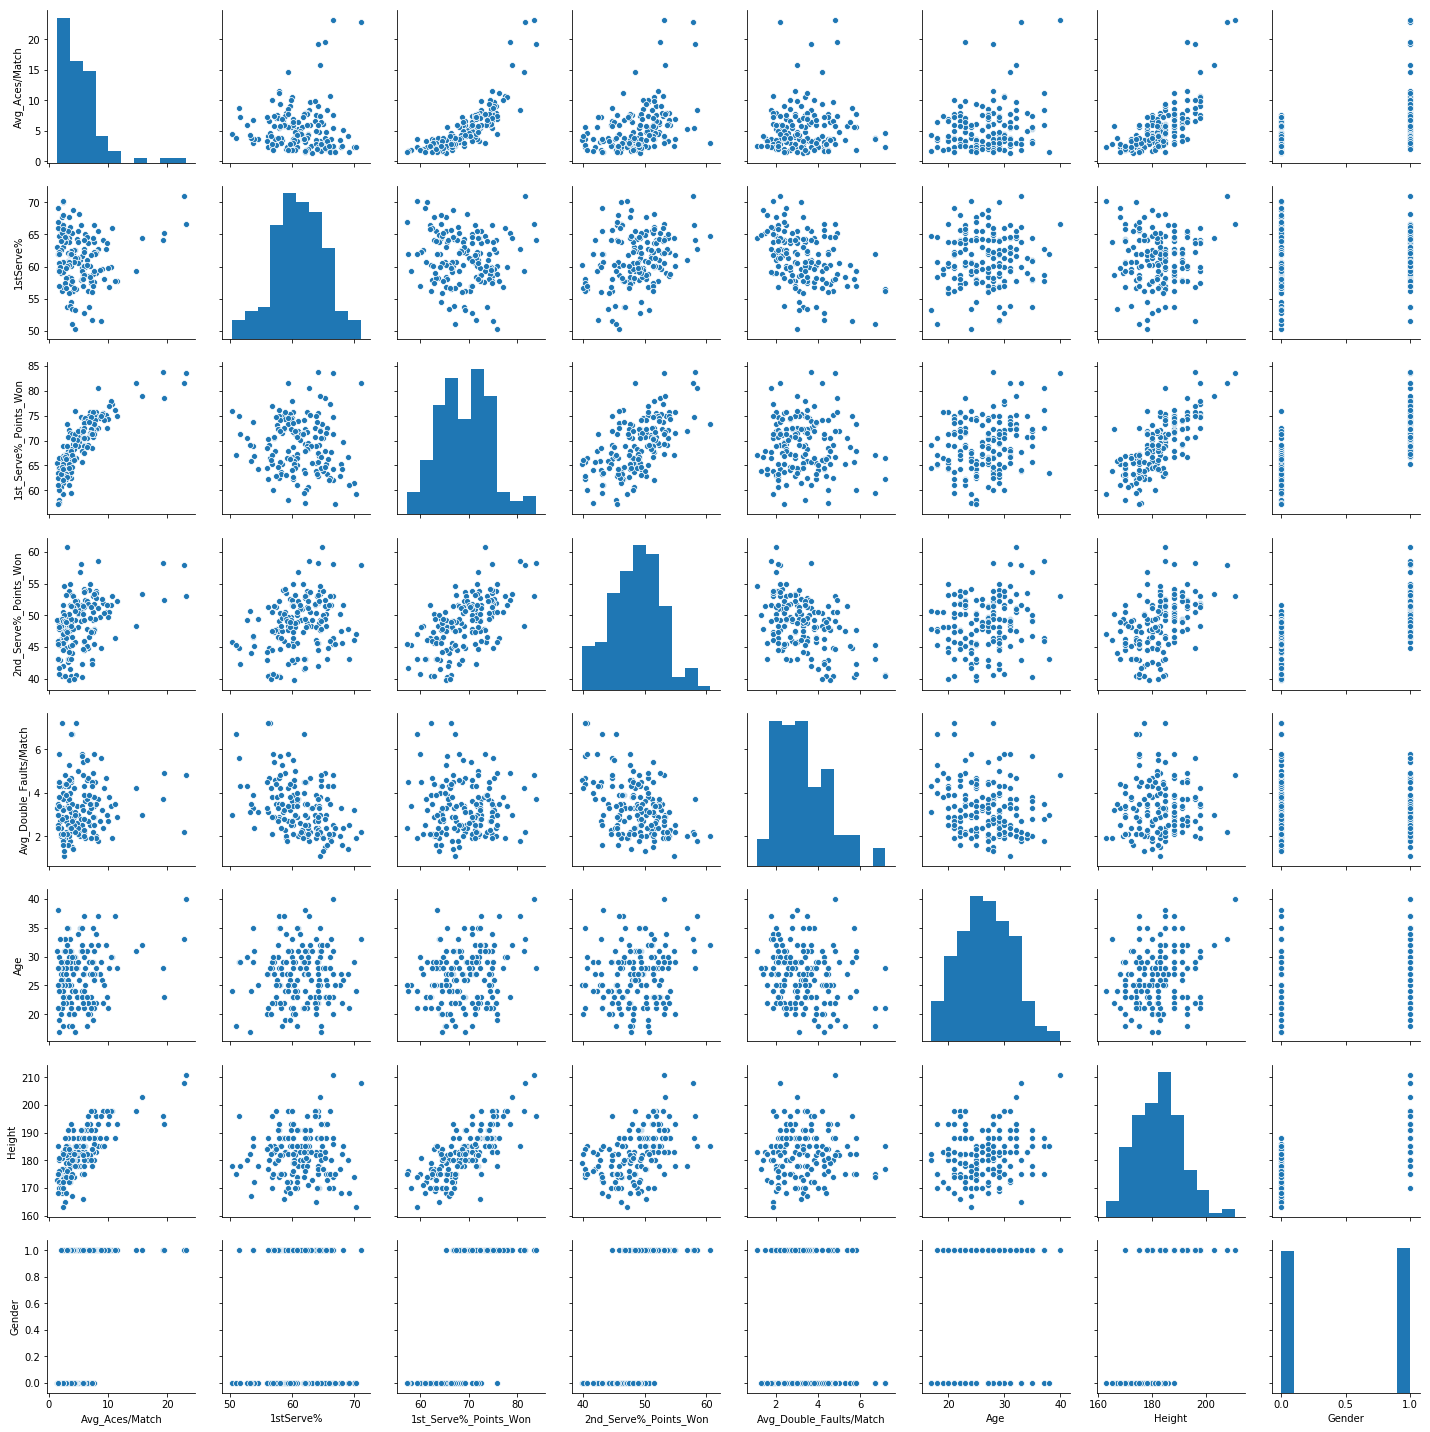

In [16]:
sns.pairplot(tennis);

In [17]:
#Retrieving column names in order to rename if necessary.
tennis.columns

Index(['Avg_Aces/Match', '1stServe%', '1st_Serve%_Points_Won',
       '2nd_Serve%_Points_Won', 'Avg_Double_Faults/Match', 'Age', 'Height',
       'Gender'],
      dtype='object')

In [18]:
#Renaming some column names
tennis.columns = ['Avg_Aces_Match', '1stServe_perc', '1st_Serve_perc_Points_Won',
       '2nd_Serve_perc_Points_Won', 'Avg_Double_Faults_Match', 'Age',
       'Height', 'Gender']

In [19]:
#checking to make sure the types are correct.
tennis.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162 entries, John Isner to  Kateryna Kozlova
Data columns (total 8 columns):
Avg_Aces_Match               162 non-null float64
1stServe_perc                162 non-null float64
1st_Serve_perc_Points_Won    162 non-null float64
2nd_Serve_perc_Points_Won    162 non-null float64
Avg_Double_Faults_Match      162 non-null float64
Age                          162 non-null float64
Height                       162 non-null float64
Gender                       162 non-null uint8
dtypes: float64(7), uint8(1)
memory usage: 15.3+ KB


## Simple Validation Method: Train / Validation / Test
## Ridge Regularization
## LASSO Regularization
## Linear Regression with 2nd degree polynomial features

In [20]:
#Splitting/Setting X as the independent variables and y to the dependent variable.
X, y = tennis.drop('Avg_Aces_Match', axis=1), tennis['Avg_Aces_Match']

In [21]:
#10%(X_test) will be used as the final test.
#the remaining 90% will be split for traning and validation.
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=.1, random_state=10)


In [22]:
#This cell is for traning purposes only. Plug and chug different alphas to come up
#with the best alpha.
kf = KFold(n_splits=3, shuffle=True, random_state = 71)

ridge_alpha_scores = {}
lass_alpha_scores = {}

for x in np.linspace(0,.2,50):
    ridge_scores = []
    lass_scores = []
    
    
    for tr, te in kf.split(X_train, y_train):
        X_tr,X_te = X_train.iloc[tr] ,X_train.iloc[te]
        y_tr,y_te = y_train.iloc[tr] ,y_train.iloc[te]


        tennisLr_ridge = Ridge(alpha=x)
        tennisLr_lass = Lasso(alpha=x)
        scaler = StandardScaler()


        X_tr_scaled = scaler.fit_transform(X_tr.values)
        X_te_scaled = scaler.transform(X_te.values)

        tennisLr_ridge.fit(X_tr_scaled, y_tr)
        tennisLr_lass.fit(X_tr_scaled, y_tr)
        
        ridge_scores.append(tennisLr_ridge.score(X_te_scaled,y_te))
        lass_scores.append(tennisLr_lass.score(X_te_scaled, y_te))
    
    ridge_alpha_scores[x] = np.mean(ridge_scores)
    lass_alpha_scores[x] = np.mean(lass_scores)
    


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:478: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:478: UserWarning: Coordinate descent with no regularization may lead

In [23]:
lass_alpha_scores

{0.0: 0.6821329712029739,
 0.004081632653061225: 0.6830280536817259,
 0.00816326530612245: 0.683880937529139,
 0.012244897959183675: 0.6847168422046597,
 0.0163265306122449: 0.685519017078365,
 0.020408163265306124: 0.6862693299594277,
 0.02448979591836735: 0.6869678032856932,
 0.028571428571428574: 0.6876144401875336,
 0.0326530612244898: 0.6882122248139985,
 0.036734693877551024: 0.6887554704509194,
 0.04081632653061225: 0.6892468882557964,
 0.04489795918367347: 0.689689863685938,
 0.0489795918367347: 0.690078097998111,
 0.05306122448979592: 0.6904143106647161,
 0.05714285714285715: 0.6906986925201432,
 0.06122448979591837: 0.6909312530876969,
 0.0653061224489796: 0.6911119935123474,
 0.06938775510204082: 0.691240914003342,
 0.07346938775510205: 0.6913180145606802,
 0.07755102040816328: 0.6913838169399691,
 0.0816326530612245: 0.6914257742700883,
 0.08571428571428572: 0.6914306640085089,
 0.08979591836734695: 0.6914428903359838,
 0.09387755102040818: 0.6914096267679796,
 0.0979591836

In [24]:
#Choose the model, alpha, and features. I decided to eliminate the ridge regression for this 
#assignment.
kf = KFold(n_splits=3, shuffle=True, random_state = 71)
cv_lr_list_Rsq = []
cv_lasso_list_Rsq = []

for tr, te in kf.split(X_train, y_train):
    X_tr,X_te = X_train.iloc[tr] ,X_train.iloc[te]
    y_tr,y_te = y_train.iloc[tr] ,y_train.iloc[te]


    tennisLr = LinearRegression()

    tennisLr_lass = Lasso(alpha=0.08979591836734695)

    scaler = StandardScaler()
    

    X_tr_scaled = scaler.fit_transform(X_tr.values)
    X_te_scaled = scaler.transform(X_te.values)
    
    tennisLr.fit(X_tr, y_tr)
    cv_lr_list_Rsq.append(tennisLr.score(X_te, y_te))

    tennisLr_lass.fit(X_tr_scaled, y_tr)
    cv_lasso_list_Rsq.append(tennisLr_lass.score(X_te_scaled, y_te))



In [25]:
np.mean(cv_lr_list_Rsq)

0.6821329712029738

In [26]:
np.mean(cv_lasso_list_Rsq)

0.6914428903359838

In [27]:
tennisLr.intercept_

-57.209199129017236

In [28]:
tennisLr.coef_

array([ 0.14417553,  0.49838993, -0.05253615,  0.13922053,  0.02509869,
        0.11692826, -1.32092376])

In [29]:
#the test columns
test_tennis_columns = tennis.columns[1:]
test_tennis_columns

Index(['1stServe_perc', '1st_Serve_perc_Points_Won',
       '2nd_Serve_perc_Points_Won', 'Avg_Double_Faults_Match', 'Age', 'Height',
       'Gender'],
      dtype='object')

In [30]:
#Now let's do the same but with KFolds, using a different random_state.

# X, y = cars.drop('price',axis=1), cars['price'] 
# X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10)
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=43)

In [31]:
#Running against holdout.

tennisLr_lass = Lasso(alpha=0.08979591836734695)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_holdout = scaler.transform(X_holdout)


tennisLr_lass.fit(X_train, y_train)
holdout_set_pred = tennisLr_lass.predict(X_holdout)

resids = y_holdout - holdout_set_pred

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


In [32]:
resids

Player
Kei Nishikori            -1.789887
 Monica Puig              0.635523
Richard Gasquet          -0.100178
Kyle Edmund              -1.653692
 Kristyna Pliskova        1.720274
 Danielle Collins         1.841218
 Stefanie Voegele         0.804711
Karen Khachanov          -0.924457
David Goffin             -0.214489
 Samantha Stosur          1.830047
Guillermo Garcia-Lopez   -2.746454
Matthew Ebden            -0.563495
Fernando Verdasco        -0.075909
Philipp Kohlschreiber    -0.121500
Denis Shapovalov         -1.070304
 Saisai Zheng             3.198797
 Dayana Yastremska        0.212809
Name: Avg_Aces_Match, dtype: float64

In [33]:
y_holdout.max()

9.1

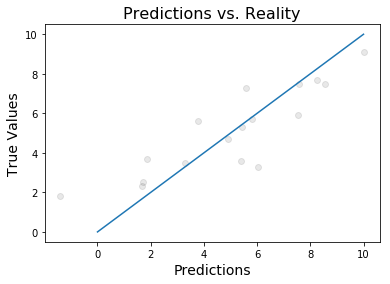

In [34]:
plt.scatter(holdout_set_pred, y_holdout, alpha=0.08979591836734695, color='black');
plt.plot([0,10],[0,10]);
plt.title('Predictions vs. Reality', fontsize=16);
plt.xlabel('Predictions', fontsize=14);
plt.ylabel('True Values', fontsize=14);

In [35]:
list(zip(tennis.columns, tennisLr_lass.coef_))

[('Avg_Aces_Match', 0.5607628220244267),
 ('1stServe_perc', 2.860516253369943),
 ('1st_Serve_perc_Points_Won', -0.08680221750159496),
 ('2nd_Serve_perc_Points_Won', 0.3467252219726419),
 ('Avg_Double_Faults_Match', 0.021497820677196442),
 ('Age', 0.9230053707001451),
 ('Height', -0.5138706200202925)]

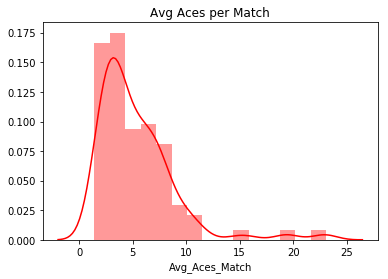

In [36]:
sns.distplot(tennis.Avg_Aces_Match, color='r').set_title('Avg Aces per Match');
